In [7]:
# ================================
# STEP 1: Install dependencies
# ================================
!pip install -q timm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import timm
import math
import numpy as np
from tqdm import tqdm
import os   # ✅ <-- add this here
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ================================
# STEP 2: Mount Google Drive (SAVE MODELS HERE)
# ================================
from google.colab import drive
drive.mount('/content/drive')

CHECKPOINT_DIR = "/content/drive/MyDrive/AIRL_Checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)


Device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# ================================
# STEP 2: Hyperparameters
# ================================
NUM_EPOCHS = 15            # good start, increase to 80 if time allows
BATCH_SIZE = 128
IMAGE_SIZE = 224           # pretrained ViTs expect 224x224
LR = 3e-4
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 3
NUM_CLASSES = 10
MODEL_NAME = "deit_base_distilled_patch16_224"  # Distilled DeiT gives very high accuracy



In [9]:
# ================================
# STEP 3: Data Augmentation
# Strong augmentation is critical to boost generalization
# ================================
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.08, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

test_transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE/0.875)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


In [10]:
# ================================
# STEP 4: Load Pretrained Model
# ================================
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/349M [00:00<?, ?B/s]

In [11]:
# ================================
# STEP 5: Learning Rate Scheduler (Warmup + Cosine Decay)
# ================================
def get_lr_lambda(total_epochs, steps_per_epoch, warmup_epochs):
    total_iters = total_epochs * steps_per_epoch
    warmup_iters = warmup_epochs * steps_per_epoch
    def lr_lambda(iteration):
        if iteration < warmup_iters:
            return float(iteration) / float(max(1, warmup_iters))
        progress = float(iteration - warmup_iters) / float(max(1, total_iters - warmup_iters))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return lr_lambda

steps_per_epoch = len(trainloader)
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, lr_lambda=get_lr_lambda(NUM_EPOCHS, steps_per_epoch, WARMUP_EPOCHS)
)


/tmp/ipython-input-3140309599.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Epoch 1/15:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-3140309599.py:61: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 1, Loss: 1.1188, Train Acc: 73.68%, Val Acc: 96.65%
New Best Model Saved: 96.65%


Epoch 2/15: 100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


Epoch 2, Loss: 0.8237, Train Acc: 86.13%, Val Acc: 96.14%


Epoch 3/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 3, Loss: 0.8286, Train Acc: 85.73%, Val Acc: 96.24%


Epoch 4/15: 100%|██████████| 391/391 [06:48<00:00,  1.04s/it]


Epoch 4, Loss: 0.8325, Train Acc: 85.48%, Val Acc: 95.76%


Epoch 5/15: 100%|██████████| 391/391 [06:48<00:00,  1.04s/it]


Epoch 5, Loss: 0.8010, Train Acc: 86.85%, Val Acc: 96.78%
New Best Model Saved: 96.78%


Epoch 6/15: 100%|██████████| 391/391 [06:48<00:00,  1.05s/it]


Epoch 6, Loss: 0.7839, Train Acc: 87.55%, Val Acc: 96.49%


Epoch 7/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 7, Loss: 0.7618, Train Acc: 88.59%, Val Acc: 96.87%
New Best Model Saved: 96.87%


Epoch 8/15: 100%|██████████| 391/391 [06:48<00:00,  1.05s/it]


Epoch 8, Loss: 0.7397, Train Acc: 89.50%, Val Acc: 97.36%
New Best Model Saved: 97.36%


Epoch 9/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 9, Loss: 0.7131, Train Acc: 90.70%, Val Acc: 97.40%
New Best Model Saved: 97.40%


Epoch 10/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 10, Loss: 0.6964, Train Acc: 91.41%, Val Acc: 98.08%
New Best Model Saved: 98.08%


Epoch 11/15: 100%|██████████| 391/391 [06:50<00:00,  1.05s/it]


Epoch 11, Loss: 0.6721, Train Acc: 92.46%, Val Acc: 98.02%


Epoch 12/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 12, Loss: 0.6562, Train Acc: 93.01%, Val Acc: 98.30%
New Best Model Saved: 98.30%


Epoch 13/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 13, Loss: 0.6366, Train Acc: 94.01%, Val Acc: 98.36%
New Best Model Saved: 98.36%


Epoch 14/15: 100%|██████████| 391/391 [06:49<00:00,  1.05s/it]


Epoch 14, Loss: 0.6345, Train Acc: 94.00%, Val Acc: 98.52%
New Best Model Saved: 98.52%


Epoch 15/15: 100%|██████████| 391/391 [06:48<00:00,  1.05s/it]


Epoch 15, Loss: 0.6307, Train Acc: 94.22%, Val Acc: 98.51%


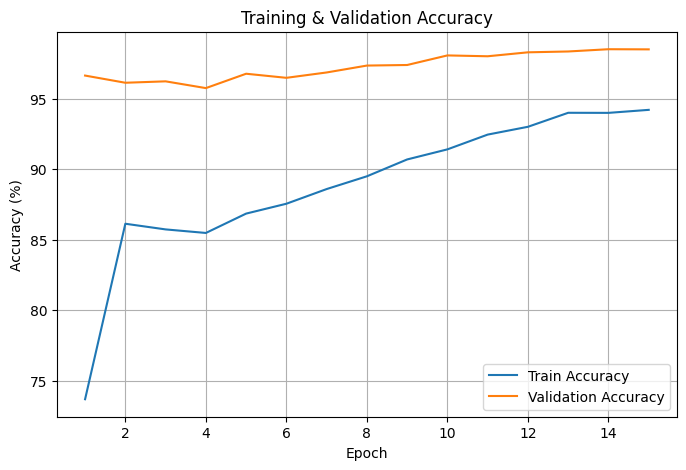

Accuracy curve saved at: /content/checkpoints/accuracy_curve.png


In [12]:
import os
import matplotlib.pyplot as plt

CHECKPOINT_DIR = "/content/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

best_acc = 0.0
start_epoch = 0
train_acc_history, val_acc_history = [], []

# ================================
# AMP Scaler (working version)
# ================================
scaler = torch.cuda.amp.GradScaler()

# ================================
# Load latest checkpoint if exists
# ================================
latest_ckpt = os.path.join(CHECKPOINT_DIR, "latest.pth")
if os.path.exists(latest_ckpt):
    print("Loading latest checkpoint...")
    checkpoint = torch.load(latest_ckpt, map_location=device)
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["optimizer_state"])
    scheduler.load_state_dict(checkpoint["scheduler_state"])
    best_acc = checkpoint["best_acc"]
    start_epoch = checkpoint["epoch"] + 1
    train_acc_history = checkpoint.get("train_acc_history", [])
    val_acc_history = checkpoint.get("val_acc_history", [])
    print(f"Resuming from epoch {start_epoch}, best acc so far: {best_acc:.2f}%")

# ================================
# Validation Function
# ================================
def validate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# ================================
# Training Loop with Checkpointing
# ================================
for epoch in range(start_epoch, NUM_EPOCHS):
    model.train()
    correct_train, total_train = 0, 0
    running_loss = 0.0

    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # ✅ FIX: use torch.cuda.amp.autocast (consistent)
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    # Epoch training accuracy
    train_acc = 100 * correct_train / total_train
    val_acc = validate(model, testloader)

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save checkpoint
    state = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_acc": best_acc,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history
    }
    torch.save(state, latest_ckpt)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(state, os.path.join(CHECKPOINT_DIR, "best.pth"))
        print(f"New Best Model Saved: {best_acc:.2f}%")

# ================================
# Plot and Save Accuracy Curve
# ================================
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_acc_history)+1), train_acc_history, label="Train Accuracy")
plt.plot(range(1, len(val_acc_history)+1), val_acc_history, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training & Validation Accuracy")
plt.legend()
plt.grid(True)

plot_path = os.path.join(CHECKPOINT_DIR, "accuracy_curve.png")
plt.savefig(plot_path)
plt.show()

print(f"Accuracy curve saved at: {plot_path}")
